In [1]:
import os
from numpy import *
import operator
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn.neighbors import kneighbors_graph,NearestNeighbors
from sklearn import datasets
import random as rd 

import seaborn as sns
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture as GMM

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def optimalApproxiamtion(data,m_end=30,random_state=0,covariance_type='diag',plot=False):
        n_components = arange(2, m_end,1)
        models = [GMM(n, covariance_type=covariance_type, random_state=random_state).fit(data)
                  for n in n_components]
        bics=array([m.bic(data) for m in models])
        if plot==True:
            plt.plot(n_components, bics, label='J(M_t)')

            plt.legend(loc='best')
            plt.xlabel('t',fontsize=18)
            print('best bic',n_components[bics.argmin()])
            print('best bic',bics[bics.argmin()])
            plt.text(n_components[bics.argmin()],bics.min()-2,'x',fontsize=15)
        optimal_t=n_components[bics.argmin()]
        best_Mt=models[bics.argmin()]
  
        return optimal_t,best_Mt

In [3]:
def compressedSimilarityMatrix(X,Mt,plot=False,gmm=None):
    t=Mt.n_components
    labels=Mt.predict(X)
    probabilities=Mt.predict_proba(X)
    sm=zeros((t,t))
    
    for i in range(t):
        sm[i]=probabilities[labels==i].sum(axis=0)
        sm[i,i]=0
    S=sm+sm.T
    
    if plot==True:
        plt.figure(figsize=(14,14))
        plt.subplot(2,2,1)
        SubCluster_display(X,labels,figsize=None,markSize=[100,600,300],gmm=gmm)
        plt.xticks(())
        plt.yticks(())
        plt.axis('off')
        plt.subplot(2,2,2)
        sns.heatmap(sm,robust =False,square=True,linewidths=0.004,vmin=0.0)
    
    return S

def SubCluster_display(data,C,figsize=(10,8),markSize=[100,1000,1200],gmm=None):
    if figsize!=None:
        plt.figure(figsize=figsize)
    clusterNos=pd.unique(C)
    if gmm!=None:
        plot_gmm(gmm, data)
    for i in clusterNos:
        cluster=data[C==i]
        #print('i=',i),print(cluster.shape[0])
        
        
        
        plt.scatter(cluster[:,0],cluster[:,1],s=markSize[0],marker='$'+str(i)+'$')
            
        if i>=10:
            plt.scatter(cluster.mean(axis=0)[0],cluster.mean(axis=0)[1],s=markSize[1],marker='$'+str(i)+'$',c='black')
        else:
            plt.scatter(cluster.mean(axis=0)[0],cluster.mean(axis=0)[1],s=markSize[2],marker='$'+str(i)+'$',c='black')

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        print(1)
        ax.scatter(X[:, 0], X[:, 1],  s=4, cmap='viridis', zorder=2)#c=labels,
    else:
        ax.scatter(X[:, 0], X[:, 1], s=4, zorder=2)
    #ax.axis('equal')
    w_factor = 0.4 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_  , gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)            
        
from matplotlib.patches import Ellipse


def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
   
    if covariance.shape == (2, 2):
        U, s, Vt = linalg.svd(covariance)
        angle = degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * sqrt(s)
    else:
        angle = 0
        width, height = 2 * sqrt(covariance)

 
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

In [4]:
def SingleLink_Agg(S):
    
    S=triu(S,1)
    t=S.shape[0]
    h=arange(t)
    #H=tile(h,(t,1))
    H=zeros((t,t))-1
    H[0]=arange(t)
    T=zeros((t-1,7))-1
    N=0
    T_No=t
    #print('H_0',H)
    while N<=t-2:
        #print('round',N)
        #print('H',H)
        s=S.max()
        #print(S.argmax())
        i,j=int(floor(S.argmax()/11)),   S.argmax()%11
        #print(i,j)
        T_No_i=int(H[N,i])
        T_No_j=int(H[N,j])
        #print('T_No_i,T_No_j')
        #print(T_No_i,T_No_j)
        index_i=where(H[N]==T_No_i)[0]
        index_j=where(H[N]==T_No_j)[0]
        #print('index_i',index_i)
        H[N+1]=H[N]
        H[N+1,index_i]=T_No
        #print('H[N+1,:]',H[N+1,:])
        H[N+1,index_j]=T_No
        
        if T_No_i<t and T_No_j<t:
            #print('1')
            
            T[N]=T_No_i,T_No_j,-1,s,-1,T_No,0
        elif T_No_i<t:
            #print('2')
            
            s=T[T_No_j-t,3]
            T[N]=T_No_i,T_No_j,-1,s,-1,T_No,1
            T[T_No_j-t,2]=T_No
        elif T_No_j<t:
            #print('3')
            #print(T_No_i-t)
            #print(T[T_No_i-t,3])
            s=T[T_No_i-t,3]
            T[N]=T_No_j,T_No_i,-1,s,-1,T_No,1
            T[T_No_i-t,2]=T_No
        elif T_No_i!=T_No_j:
            #print('4')
           
            T[N]=T_No_i,T_No_j,-1,s,-1,T_No,2
            #print(T_No_i,t,T_No_i-t)
            
            T[T_No_i-t,2]=T_No
            T[T_No_i-t,4]=(T[T_No_i-t,3]-s)
            
            T[T_No_j-t,2]=T_No
            T[T_No_j-t,4]=(T[T_No_j-t,3]-s)
        N+=1
        T_No+=1
        S[i,j]=0
    #print('H_1',H)
        
    return H,T        
            

In [5]:
def test(X,m_end=30,random_state=0,covariance_type='diag'):
    t,Mt=optimalApproxiamtion(X,m_end=m_end,random_state=random_state,covariance_type=covariance_type)
    S=compressedSimilarityMatrix(X,Mt)
    H,T=SingleLink_Agg(S)
    return t,Mt,S,H,T

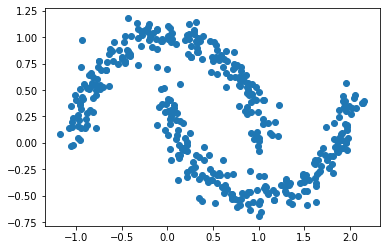

In [6]:
moon,moon_y = datasets.make_moons(400, noise=.09, random_state=3)
plt.scatter(moon[:, 0], moon[:, 1])

best bic 11
best bic 1101.2133422427573


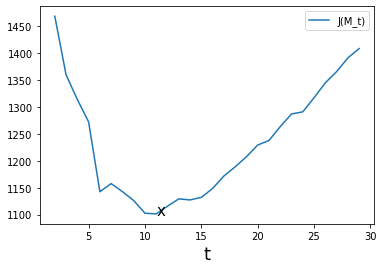

In [7]:
t,Mt=optimalApproxiamtion(moon,m_end=30,random_state=0,covariance_type='diag',plot=True)

1


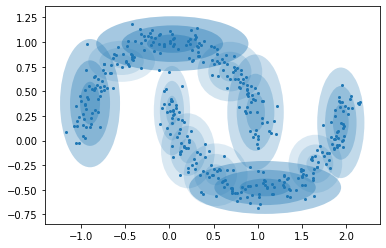

In [8]:
plot_gmm(Mt, moon, label=True, ax=None)

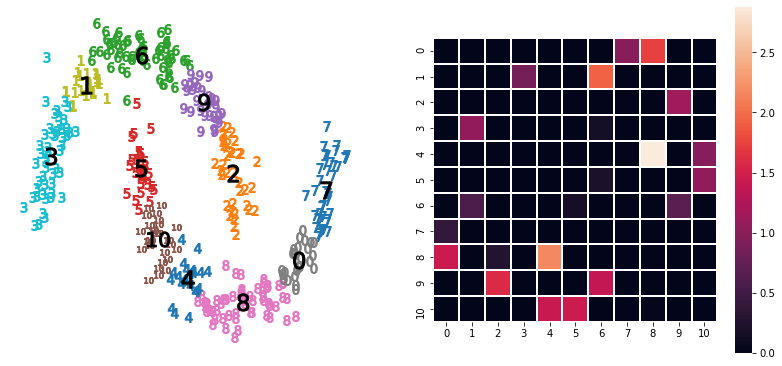

In [9]:
S=compressedSimilarityMatrix(moon,Mt,plot=True)

In [10]:
Returns=test(moon,m_end=30,covariance_type='diag',random_state=0)

In [11]:
S,H,T=Returns[2:]
S,H,T

(array([[0.00000000e+000, 8.25101388e-102, 1.97566869e-005,
         1.15436868e-098, 6.27965993e-014, 1.35121823e-050,
         2.75119557e-034, 1.37166126e+000, 3.16455572e+000,
         5.22247035e-027, 3.33193853e-033],
        [8.25101388e-102, 0.00000000e+000, 2.26555019e-030,
         1.90965454e+000, 2.57259941e-033, 1.02428578e-003,
         2.51666523e+000, 7.63818740e-088, 2.70547267e-044,
         3.99110362e-014, 2.07770701e-015],
        [1.97566869e-005, 2.26555019e-030, 0.00000000e+000,
         3.13145573e-048, 4.02108566e-003, 1.87240828e-012,
         7.23822515e-006, 5.94680371e-011, 2.64141748e-001,
         2.73001929e+000, 9.58730851e-007],
        [1.15436868e-098, 1.90965454e+000, 3.13145573e-048,
         0.00000000e+000, 8.88659270e-029, 2.07377205e-010,
         1.48153938e-001, 1.18495522e-117, 1.02185888e-016,
         1.61269868e-025, 1.61509631e-015],
        [6.27965993e-014, 2.57259941e-033, 4.02108566e-003,
         8.88659270e-029, 0.00000000e+000, 7